In [1]:
import numpy as np
import re
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

def softmax(x):
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum(axis = 0)

In [2]:
class SkipGram(nn.Module):
    def __init__(self, vocab_size, embedding_dim): 
        super().__init__()
        self.vocab_size = vocab_size # Vocab * Word
        self.embedding_dim = embedding_dim
        
        self.W = nn.Parameter(torch.randn((self.embedding_dim, self.vocab_size), dtype = torch.float64)) # Embedding * Vocab
        self.W1 = nn.Parameter(torch.randn((self.vocab_size, self.embedding_dim), dtype = torch.float64)) # Vocab * Embedding
    
    def forward(self, x):
        self.hidden = torch.matmul(self.W, x) # Embedding * Word
        self.output = torch.matmul(self.W1, self.hidden) # Vocab * Word
        return self.output
    
    def getEmbedding(self, x):
        return self.W[:, x]

In [3]:
def preprocessing(text):
    _ = re.findall(r"[A-Za-z]+", text)
    words = []
    for word in _:
        words.append(word.lower())
    word2id = {w : i for i, w in enumerate(set(words))}
    return words, word2id

def generateData(words, word2id):
    vocab_size = len(word2id)
    word_size = len(words)
    window_len = 5
    x_train = np.zeros((vocab_size, word_size - window_len + 1))
    y_train = np.zeros((vocab_size, word_size - window_len + 1))
    for _ in range(window_len // 2, word_size - window_len // 2):
        x_train[word2id[words[_]]][_ - window_len // 2] = 1
        for __ in range(_ - window_len // 2, _):
            y_train[word2id[words[__]]][_ - window_len // 2] = 1 / (window_len - 1)
        for __ in range(_ + window_len // 2, _, -1):
            y_train[word2id[words[__]]][_ - window_len // 2] = 1 / (window_len - 1)
    return torch.tensor(x_train), torch.tensor(y_train) # one-hot is column

with open("input.txt", 'r') as f:
    text = f.read()

words, word2id = preprocessing(text)
x_train, y_train = generateData(words, word2id)

In [4]:
def train(x_train, y_train, embedding_dim):
    model = SkipGram(x_train.shape[0], embedding_dim)
    print(x_train.dtype)
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters())

    num_epoches = 5000

    for epoch in range(num_epoches):
        model.train()
        optimizer.zero_grad()
        output = model(x_train)
        loss = criterion(output, y_train)
        loss.backward()
        optimizer.step()
        if epoch % 10 == 0:
            print(f"Epoch {epoch}, Loss: {loss.item()}")
    
    return model

In [7]:
model = train(x_train, y_train, 5)

word2embed = {}
for (word, id) in word2id.items():
    embedding = model.getEmbedding(id).detach().numpy()
    print(word, id, embedding)
    word2embed[word] = embedding

with open("output.txt", 'w') as f:
    for (word, embed) in word2embed.items():
        f.write(word)
        f.write(str(embed))

torch.float64
Epoch 0, Loss: 1.0918906981863914
Epoch 10, Loss: 1.079251149370609
Epoch 20, Loss: 1.0668930744392937
Epoch 30, Loss: 1.054832795370426
Epoch 40, Loss: 1.0430705763193393
Epoch 50, Loss: 1.0315973324191243
Epoch 60, Loss: 1.0203982547804376
Epoch 70, Loss: 1.009455312722122
Epoch 80, Loss: 0.9987489371389466
Epoch 90, Loss: 0.9882591426659125
Epoch 100, Loss: 0.9779661003631621
Epoch 110, Loss: 0.9678502981997267
Epoch 120, Loss: 0.9578925203172785
Epoch 130, Loss: 0.9480737766040196
Epoch 140, Loss: 0.9383752194721234
Epoch 150, Loss: 0.9287780596692824
Epoch 160, Loss: 0.9192634964023121
Epoch 170, Loss: 0.9098126781456284
Epoch 180, Loss: 0.9004067040014148
Epoch 190, Loss: 0.8910266667523927
Epoch 200, Loss: 0.881653732541766
Epoch 210, Loss: 0.8722692495025212
Epoch 220, Loss: 0.8628548775573371
Epoch 230, Loss: 0.8533927326260806
Epoch 240, Loss: 0.8438655397209673
Epoch 250, Loss: 0.8342567905433522
Epoch 260, Loss: 0.8245509021845896
Epoch 270, Loss: 0.8147333743

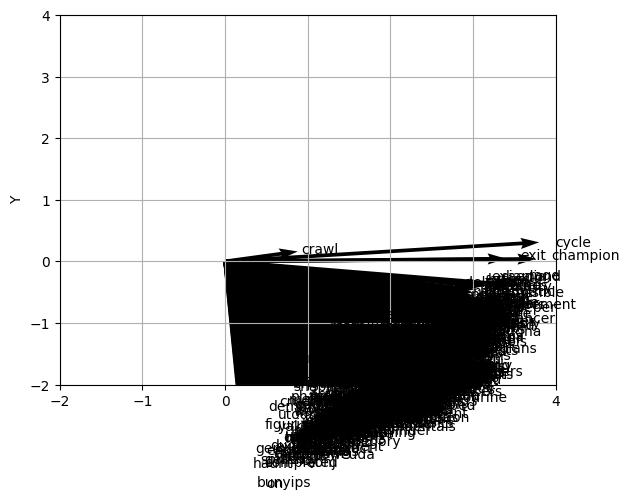

In [ ]:
fig, ax = plt.subplots()

for word, embedding in word2embed.items():
    ax.quiver(0, 0, embedding[0], embedding[1], scale = 6)
    ax.text(embedding[0] * 1.05, embedding[1] * 1.05, word)

ax.set_xlim(-2, 4)
ax.set_ylim(-2, 4)
ax.grid(True)
ax.set_xlabel('X')
ax.set_ylabel('Y')
plt.show()

In [ ]:
class Word2VecSkipGram:
    def __init__(self, vocab_size, embedding_dim=10, window_size=2, learning_rate=0.01):
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.window_size = window_size
        self.learning_rate = learning_rate
        
        # Initialize weights randomly
        self.W = np.random.uniform(-0.8, 0.8, (self.vocab_size, self.embedding_dim))  # Input to hidden
        self.W1 = np.random.uniform(-0.8, 0.8, (self.embedding_dim, self.vocab_size)) # Hidden to output

    def forward(self, x):
        # x is one-hot vector (vocab_size x 1)
        self.h = np.dot(self.W.T, x)              # hidden layer (embedding_dim x 1)
        self.u = np.dot(self.W1.T, self.h)        # output layer (vocab_size x 1)
        self.y_pred = softmax(self.u)              # predicted probabilities
        return self.y_pred

    def backprop(self, x, t):
        # x: input one-hot vector, t: target one-hot vector
        e = self.y_pred - t                        # error vector (vocab_size x 1)
        dW1 = np.dot(self.h, e.T)                  # gradient for W1
        dW = np.dot(x, np.dot(self.W1, e).T)      # gradient for W

        # Update weights
        self.W1 -= self.learning_rate * dW1
        self.W -= self.learning_rate * dW

    def train(self, X_train, y_train, epochs=1000):
        for epoch in range(epochs):
            loss = 0
            for x, t in zip(X_train, y_train):
                x = x.reshape(self.vocab_size, 1)
                t = t.reshape(self.vocab_size, 1)
                y_pred = self.forward(x)
                loss -= np.sum(t * np.log(y_pred + 1e-9))  # cross-entropy loss
                self.backprop(x, t)
            if (epoch + 1) % 100 == 0:
                print(f"Epoch {epoch+1}, Loss: {loss}")

    def get_embedding(self, word_index):
        # Return the embedding vector for a given word index
        return self.W[word_index]

    def predict(self, word, word_to_index, index_to_word, top_n=3):
        # Predict top N context words for a given input word
        x = np.zeros(self.vocab_size)
        x[word_to_index[word]] = 1
        y_pred = self.forward(x.reshape(self.vocab_size, 1))
        top_indices = y_pred.flatten().argsort()[-top_n:][::-1]
        return [index_to_word[i] for i in top_indices]

# Preprocessing function to clean and tokenize corpus
def preprocess_corpus(corpus):
    stop_words = set(stopwords.words('english'))
    corpus = corpus.lower()
    corpus = corpus.translate(str.maketrans('', '', string.punctuation))
    words = [word for word in corpus.split() if word not in stop_words]
    return words

# Prepare training data for skip-gram: center word and context words as one-hot vectors
def prepare_training_data(words, window_size, word_to_index, vocab_size):
    X_train = []
    y_train = []
    for i, center_word in enumerate(words):
        center_word_vec = np.zeros(vocab_size)
        center_word_vec[word_to_index[center_word]] = 1
        context_vec = np.zeros(vocab_size)
        # Collect context words in the window
        for j in range(i - window_size, i + window_size + 1):
            if j != i and 0 <= j < len(words):
                context_vec[word_to_index[words[j]]] = 1
        X_train.append(center_word_vec)
        y_train.append(context_vec)
    return np.array(X_train), np.array(y_train)

# Example usage
if __name__ == "__main__":
    corpus = "The earth revolves around the sun. The moon revolves around the earth."
    words = preprocess_corpus(corpus)
    vocab = sorted(set(words))
    word_to_index = {w: i for i, w in enumerate(vocab)}
    index_to_word = {i: w for w, i in word_to_index.items()}
    vocab_size = len(vocab)

    window_size = 2
    embedding_dim = 10
    learning_rate = 0.01
    epochs = 1000

    X_train, y_train = prepare_training_data(words, window_size, word_to_index, vocab_size)

    model = Word2VecSkipGram(vocab_size, embedding_dim, window_size, learning_rate)
    model.train(X_train, y_train, epochs)

    # Predict top 3 context words for "around"
    print("Top context words for 'around':", model.predict("around", word_to_index, index_to_word, top_n=3))